In [1]:
# Transformer
''' 
10.6.2节中⽐较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。值得注意的是，
自注意力同时具有并⾏计算和最短的最⼤路径⻓度这两个优势。因此，使用自注意力来设计深度架构是很有
吸引力的。对⽐之前仍然依赖循环神经网络实现输入表示的自注意力模型 (Cheng et al., 2016, Lin et al., 2017,
Paulus et al., 2017)，Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层 (Vaswani et
al., 2017)。尽管Transformer最初是应用于在⽂本数据上的序列到序列学习，但现在已经推⼴到各种现代的
深度学习中，例如语⾔、视觉、语⾳和强化学习领域
'''
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 基于位置的前馈网络
''' 
基于位置的前馈网络对序列中的所有位置的表示进⾏变换时使用的是同⼀个多层感知机（MLP），这就是称
前馈网络是基于位置的（positionwise）的原因。在下面的实现中，输入X的形状（批量⼤⼩，时间步数或序列
⻓度，隐单元数或特征维度）将被⼀个两层的感知机转换成形状为（批量⼤⼩，时间步数，ffn_num_outputs）
的输出张量
'''
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X))) # 多层感知机

In [3]:
'''下面的例⼦显示，改变张量的最⾥层维度的尺⼨，会改变成基于位置的前馈网络的输出尺⼨。因为用同⼀个
多层感知机对所有位置上的输入进⾏变换，所以当所有这些位置的输入相同时，它们的输出也是相同的
'''
ffn = PositionWiseFFN(4, 4, 8) # 基于位置的前馈网络
ffn.eval()

PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=8, bias=True)
)

In [4]:
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.3204, -0.6180,  0.4939,  0.4320,  0.4367,  0.3950, -0.6639, -0.6005],
        [-0.3204, -0.6180,  0.4939,  0.4320,  0.4367,  0.3950, -0.6639, -0.6005],
        [-0.3204, -0.6180,  0.4939,  0.4320,  0.4367,  0.3950, -0.6639, -0.6005]],
       grad_fn=<SelectBackward0>)

In [5]:
# 残差连接和层规范
'''
现在让我们关注 图10.7.1中的加法和规范化（add&norm）组件。正如在本节开头所述，这是由残差连接和
紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。
7.5节中解释了在⼀个⼩批量的样本内基于批量规范化对数据进⾏重新中⼼化和重新缩放的调整。层规范化
和批量规范化的⽬标相同，但层规范化是基于特征维度进⾏规范化。尽管批量规范化在计算机视觉中被⼴泛
应用，但在自然语⾔处理任务中（输入通常是变⻓序列）批量规范化通常不如层规范化的效果好。
以下代码对⽐不同维度的层规范化和批量规范化的效果
'''
ln = nn.LayerNorm(2) # 层规范化
bn = nn.BatchNorm1d(2) # 批量规范化
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和⽅差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [6]:
'现在可以使用残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化⽅法使用'
#@save
class AddNorm(nn.Module):
    """残差连接后进⾏层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout) # 暂退法
        self.ln = nn.LayerNorm(normalized_shape) # 层规范化
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X) # 残差连接,其中暂退法作为正则化⽅法使用


In [7]:
'残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同'
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()


AddNorm(
  (dropout): Dropout(p=0.5, inplace=False)
  (ln): LayerNorm((3, 4), eps=1e-05, elementwise_affine=True)
)

In [8]:
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [9]:
# 编码器
'''
有了组成Transformer编码器的基础组件，现在可以先实现编码器中的⼀个层。下面的EncoderBlock类包含
两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化
'''
#@save
class EncoderBlock(nn.Module): # 编码块
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, 
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias) # 多头自注意力
        self.addnorm1 = AddNorm(norm_shape, dropout) # 残差连接后进行规范化
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens) # 基于位置的前馈网络
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [10]:
'正如从代码中所看到的，Transformer编码器中的任何层都不会改变其输入的形状'
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2]) # 有效长度
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5) # 编码块
encoder_blk.eval()


EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)

In [11]:
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [12]:
'''下面实现的Transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例。由于这里使用的是
值范围在−1和1之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平⽅
根进⾏重新缩放，然后再与位置编码相加
'''
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens) # 嵌入层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) # 位置编码
        self.blks = nn.Sequential() # 构建容器
        for i in range(num_layers): # 堆叠num_layers个EncoderBlock
            self.blks.add_module(
                f"block{str(i)}",
                EncoderBlock( # 编码块
                    key_size,
                    query_size,
                    value_size,
                    num_hiddens,
                    norm_shape,
                    ffn_num_input,
                    ffn_num_hiddens,
                    num_heads,
                    dropout,
                    use_bias,
                ),
            )
    
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平⽅根进⾏缩放，
        # 然后再与位置编码相加
        # 即嵌入层乘以嵌入维度的平方根后与位置编码相加
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks): # 从容器中读取块
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [13]:
'''下面我们指定了超参数来创建⼀个两层的Transformer编码器。Transformer编码器输出的形状是(批量⼤
⼩，时间步数目，num_hiddens)
'''
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5) # 编码器
encoder.eval()

TransformerEncoder(
  (embedding): Embedding(200, 24)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (W_q): Linear(in_features=24, out_features=24, bias=False)
        (W_k): Linear(in_features=24, out_features=24, bias=False)
        (W_v): Linear(in_features=24, out_features=24, bias=False)
        (W_o): Linear(in_features=24, out_features=24, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.5, inplace=False)
        (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=24, out_features=48, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=48, out_features=24, bias=True)
      )
      (addnorm2): AddNorm(
        (d

In [14]:
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [15]:
# 解码器
'''
如 图10.7.1所示，Transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三
个⼦层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧
随的层规范化围绕。
正如在本节前面所述，在掩蔽多头解码器自注意力层（第⼀个子层）中，查询、键和值都来自上⼀个解码器
层的输出。关于序列到序列模型（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时
间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个⽣成的。因此，在任何解码器时间
步中，只有⽣成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注
意力设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经⽣成词元的位置（即直到该查询
位置为⽌）进⾏注意力计算
'''
class DecoderBlock(nn.Module): # 解码块
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout) # 多头注意力
        self.addnorm1 = AddNorm(norm_shape, dropout) # 残差连接 + 层规范化
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens) # 基于位置的前馈网络
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1] # 解码器输出/有效长度
        # 训练阶段，输出序列的所有词元都在同⼀时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元⼀个接着⼀个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None: # 训练阶段
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1) # 预测阶段  
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每⼀⾏是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None # 预测阶段

        # 解码器自注意力(掩蔽多头注意力)
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state # 基于位置的前馈网络

In [16]:
'''为了便于在“编码器－解码器”注意力中进⾏缩放点积计算和残差连接中进⾏加法计算，编码器和解码器的
特征维度都是num_hiddens
'''
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0) # 解码器
decoder_blk.eval()

DecoderBlock(
  (attention1): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (attention2): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): Lay

In [17]:
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [18]:
'''现在我们构建了由num_layers个DecoderBlock实例组成的完整的Transformer解码器。最后，通过⼀个全连
接层计算所有vocab_size个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都
被存储下来，⽅便⽇后可视化的需要
'''
class TransformerDecoder(d2l.AttentionDecoder): # 解码器
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers): # num_layers 个解码块
            self.blks.add_module(
                f"block{str(i)}",
                DecoderBlock(
                    key_size,
                    query_size,
                    value_size,
                    num_hiddens,
                    norm_shape,
                    ffn_num_input,
                    ffn_num_hiddens,
                    num_heads,
                    dropout,
                    i,
                ),
            )
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # "编码器－解码器"自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state # 最后通过一个全连接层,计算所有vocab_size个可能的输出词元的预测值

    @property
    def attention_weights(self):
        return self._attention_weights # 存储解码器/"编码器-解码器"注意力权重以便日后可视化

loss 0.031, 7658.0 tokens/sec on cuda:0


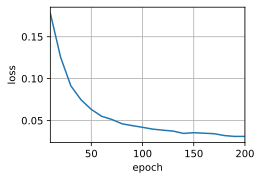

In [19]:
# 训练
'''依照Transformer架构来实例化编码器－解码器模型。在这⾥，指定Transformer的编码器和解码器都是2层，
都使用4头注意力。与 9.7.4节类似，为了进⾏序列到序列的学习，下面在“英语－法语”机器翻译数据集上
训练Transformer模型
'''
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4 # 4头注意力
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout) # Transformer 编码器

decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout) # Transformer 解码器
net = d2l.EncoderDecoder(encoder, decoder) # 编码器-解码器体系结构基类
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) # 训练序列到序列模型

In [20]:
'训练结束后，使用Transformer模型将⼀些英语句⼦翻译成法语，并且计算它们的BLEU分数'
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ', f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [21]:
'''当进行最后⼀个英语到法语的句⼦翻译工作时，让我们可视化Transformer的注意力权重。编码器自注意力
权重的形状为（编码器层数，注意力头数，num_steps或查询的数⽬，num_steps或“键－值”对的数⽬）
'''
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
                                                                             -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

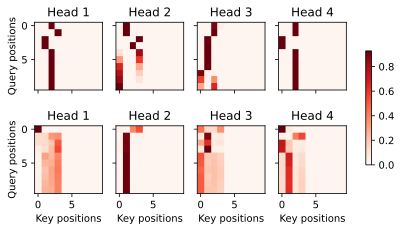

In [22]:
'''在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输
入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐⾏呈现两层多头注意力的
权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力
'''
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [25]:
'''为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作⼯作。
例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意
力权重都有相同的查询：即以序列开始词元（beginning-of-sequence,BOS）打头，再与后续输出的词元共同
组成序列
'''
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values) # 用零填充被掩蔽住注意力权重
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, 
                                                              num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape # 自注意力权重,掩蔽注意力权重

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

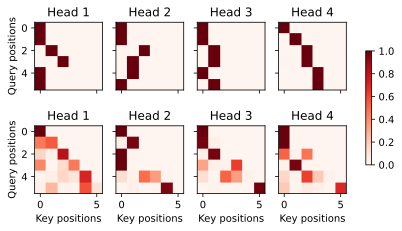

In [24]:
'由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算'
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5)) # 自注意力

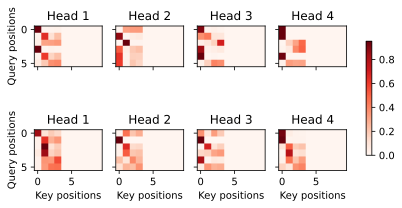

In [26]:
'''与编码器的自注意力的情况类似，通过指定输入序列的有效长度，输出序列的查询不会与输入序列中填充位
置的词元进行注意力计算
'''
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)) # 掩蔽注意力

In [ ]:
'''尽管Transformer架构是为了序列到序列的学习而提出的，但正如本书后面将提及的那样，Transformer编码
器或Transformer解码器通常被单独用于不同的深度学习任务中
------------------------------------------------------------------------------------------
⼩结
• Transformer是编码器－解码器架构的⼀个实践，尽管在实际情况中编码器或解码器可以单独使用。
• 在Transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留
自回归属性
• Transformer中的残差连接和层规范化是训练⾮常深度模型的重要⼯具
• Transformer模型中基于位置的前馈网络使用同⼀个多层感知机，作用是对所有序列位置的表示进⾏转换
'''